<a href="https://colab.research.google.com/github/almazav/Masters-Project/blob/main/Cut_off_distr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install trackml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.0 MB/s 


In [ ]:
pip install --user git+https://github.com/LAL/trackml-library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/LAL/trackml-library to /tmp/pip-req-build-3auh0ocy
  Running command git clone -q https://github.com/LAL/trackml-library /tmp/pip-req-build-3auh0ocy
  Created wheel for trackml: filename=trackml-3-py2.py3-none-any.whl size=13527 sha256=543c11d61df470cc80de75b0c4244cac663dc72ac956fba0068221e515616bce
  Stored in directory: /tmp/pip-ephem-wheel-cache-g3jgmxzo/wheels/77/4f/dc/4faf131b620e3c8dd5a6cf8ecd61e4ef0fb59b6e1f69fb9c6e
Successfully built trackml


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import numpy as np 
import pandas as pd
import trackml.dataset
import sys    
path_to_module = '/content/gdrive/MyDrive/Colab Notebooks'
sys.path.append(path_to_module)
from data_preprocess import *
import time
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

Mounted at /content/gdrive


In [ ]:
#plot parameters
FIGSIZE = (14,7)
FIGSIZE2 = (20,7)
FIG_TITLE = 22
FIG_AXIS = 14
FIG_LEGEND = 12

# Read Data

In [ ]:
#read data 
hits, particles, truth = read_all_data(1000,1004)  
df = merge_dfs(hits, particles, truth)

... read data completed in 1.2084438800811768 seconds
... merge df completed in 0.2617621421813965 seconds


In [ ]:
df.head()

,hit_id_H,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,new_hit_id,...,event_id,new_particle_id,vx,vy,vz,px,py,pz,q,nhits
0,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.4922,0.000010,1,...,1000,22525763437724648,-0.015802,0.006381,1.16279,-0.56967,-0.011187,-15.496,1,10
1,1420,22525763437723648,-55.154400,0.621779,-1497.5,-0.569794,0.027264,-15.4928,0.000008,1419,...,1000,22525763437724648,-0.015802,0.006381,1.16279,-0.56967,-0.011187,-15.496,1,10
2,1460,22525763437723648,-47.988098,0.315591,-1302.5,-0.568883,0.021994,-15.4929,0.000006,1459,...,1000,22525763437724648,-0.015802,0.006381,1.16279,-0.56967,-0.011187,-15.496,1,10
3,3170,22525763437723648,-47.804100,0.308733,-1297.5,-0.571445,0.020847,-15.4933,0.000005,3169,...,1000,22525763437724648,-0.015802,0.006381,1.16279,-0.56967,-0.011187,-15.496,1,10
4,3234,22525763437723648,-40.626099,0.087326,-1102.5,-0.569940,0.015274,-15.4934,0.000005,3233,...,1000,22525763437724648,-0.015802,0.006381,1.16279,-0.56967,-0.011187,-15.496,1,10


# Initial filters

In [ ]:

#initial filters
def weight_filter(df):
  """
     Remove weights = 0
  """
  return df.loc[df.weight!=0]

def nhit_filter(df, nhits):
  """
     Remove less than n hits
  """
  #find the amounts of hits per particle
  new_nhits = df.new_particle_id.value_counts().rename_axis('new_particle_id').reset_index(name='new_nhits') 
  #merge the new hhits on new particle id 
  df = df.merge(new_nhits, on='new_particle_id')
  return df.loc[df.new_nhits >= nhits]

def db_hit_layer_filter(df):
  """
     Remove double hits in the same layer
  """
  return df.loc[df.duplicated(subset=['new_particle_id', 'layer_id','volume_id'])==False]

def volume_filter(df, volume_list):
  """ 
     Returns only hits in volumes given in volume_list 
  """
  return df.loc[df.volume_id.isin(volume_list)]

In [ ]:
print(f"""Initial number of hits: {len(df)}""")
df = weight_filter(df)
print(f"""Number of hits after weight = 0 removal: {len(df)}""")
volume_list = [8,13,17]   #barrel
df = volume_filter(df, volume_list)
print(f"""Number of hits in volumes {volume_list} are: {len(df)}""")
df = db_hit_layer_filter(df)
print(f"""Number of hits after double hit removal: {len(df)}""")
nhits = 4
df = nhit_filter(df, nhits)
print(f"""Number of hits with less than {nhits} hits per particle: {len(df)}""")




Initial number of hits: 374398
Number of hits after weight = 0 removal: 366640
Number of hits in volumes [8, 13, 17] are: 184917
Number of hits after double hit removal: 148893
Number of hits with less than 4 hits per particle: 135355


# Calculate Initial Parameters

In [ ]:
 # Calculate derived hits variables
df['pt'] = np.sqrt(df.px**2 + df.py**2)
df['r'] = np.sqrt(df.x**2 + df.y**2)
df['phi'] = np.arctan2(df.y, df.x)
def calc_ita(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.)), theta
df['ita'], df['theta'] = calc_ita(df['r'],df['z'])
df['ita2'], df['theta2'] = calc_ita(df['pt'],df['pz'])

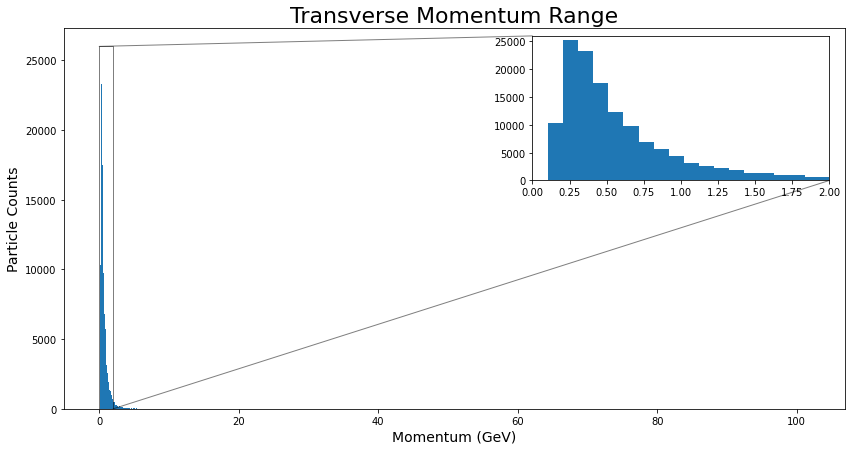

In [ ]:
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.hist(df['pt'],bins=1000)


# inset axes....
axins = ax.inset_axes([.6, 0.6, 0.38, 0.38])
axins.hist(df['pt'],bins=1000)
# sub region of the original image
x1, x2, y1, y2 = 0,2,0, 26000
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

ax.set_title('Transverse Momentum Range',fontsize=FIG_TITLE)
ax.set_xlabel('Momentum (GeV)',fontsize=FIG_AXIS)
ax.set_ylabel('Particle Counts',fontsize=FIG_AXIS)

# ax.legend(fontsize = FIG_LEGEND)
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

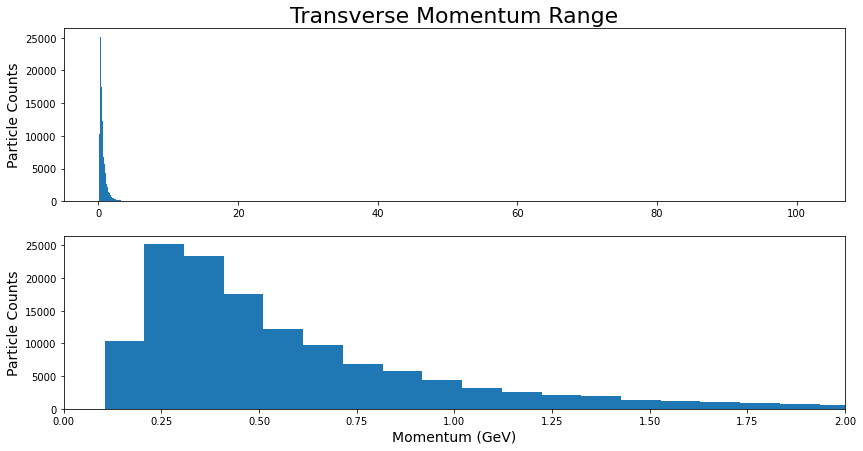

In [ ]:
#plot pt distr
fig, ax = plt.subplots(2,1,figsize = FIGSIZE)

ax[0].hist(df['pt'],bins=1000)
ax[0].set_title('Transverse Momentum Range',fontsize=FIG_TITLE)
#ax[0].set_xlabel('Momentum (GeV)',fontsize=FIG_AXIS)
ax[0].set_ylabel('Particle Counts',fontsize=FIG_AXIS)

ax[1].hist(df['pt'],bins=1000)
ax[1].set_xlim(0,2)
#ax[1].set_title('Transverse Momentum Range',fontsize=FIG_TITLE)
ax[1].set_xlabel('Momentum (GeV)',fontsize=FIG_AXIS)
ax[1].set_ylabel('Particle Counts',fontsize=FIG_AXIS)

plt.show()


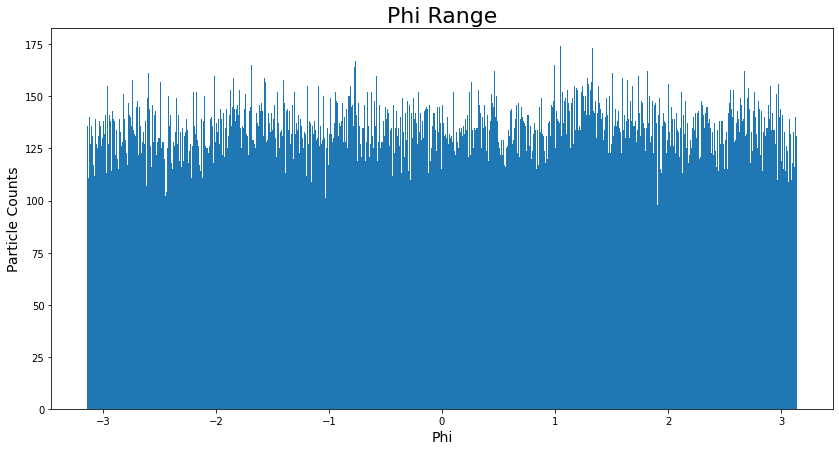

In [ ]:
#plot pt distr
fig, ax = plt.subplots(figsize = FIGSIZE)

ax.hist(df['phi'],bins=1000)
ax.set_title('Phi Range',fontsize=FIG_TITLE)
ax.set_xlabel('Phi',fontsize=FIG_AXIS)
ax.set_ylabel('Particle Counts',fontsize=FIG_AXIS)



plt.show()


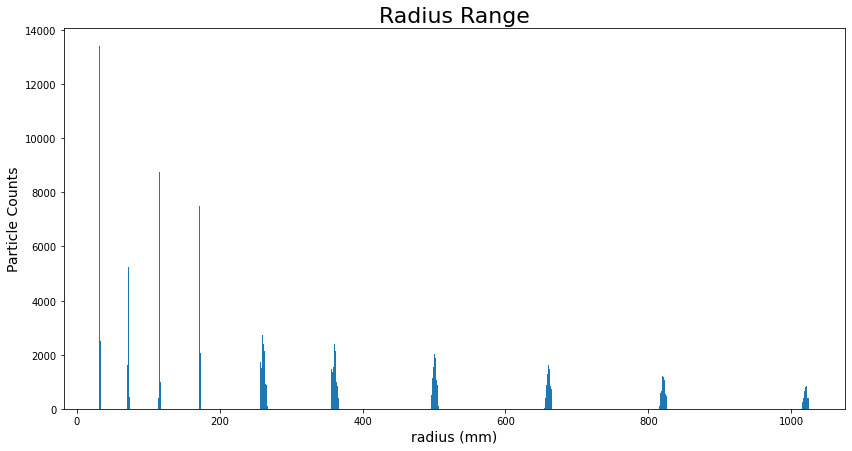

In [ ]:
#plot pt distr
fig, ax = plt.subplots(figsize = FIGSIZE)

ax.hist(df['r'],bins=1000)
ax.set_title('Radius Range',fontsize=FIG_TITLE)
ax.set_xlabel('radius (mm)',fontsize=FIG_AXIS)
ax.set_ylabel('Particle Counts',fontsize=FIG_AXIS)
plt.show()


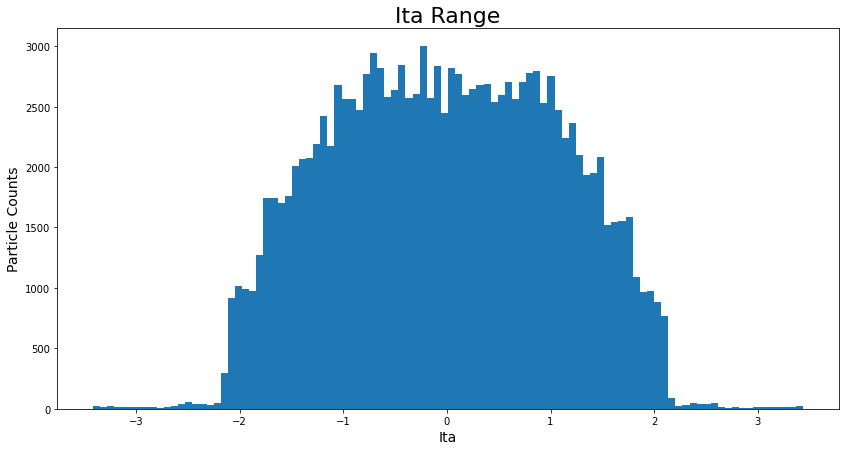

In [ ]:
#plot pt distr WHAT FILTER DIMINISH THE ETA
fig, ax = plt.subplots(figsize = FIGSIZE)

ax.hist(df['ita'],bins=100)
ax.set_title('Ita Range',fontsize=FIG_TITLE)
ax.set_xlabel('Ita',fontsize=FIG_AXIS)
ax.set_ylabel('Particle Counts',fontsize=FIG_AXIS)
plt.show()

In [ ]:
# #plot pt distr
# fig, ax = plt.subplots(figsize = FIGSIZE)

# ax.hist(df['ita2'],bins=100)
# ax.set_title('Ita2 Range',fontsize=FIG_TITLE)
# ax.set_xlabel('Ita2',fontsize=FIG_AXIS)
# ax.set_ylabel('Particle Counts',fontsize=FIG_AXIS)
# plt.show()

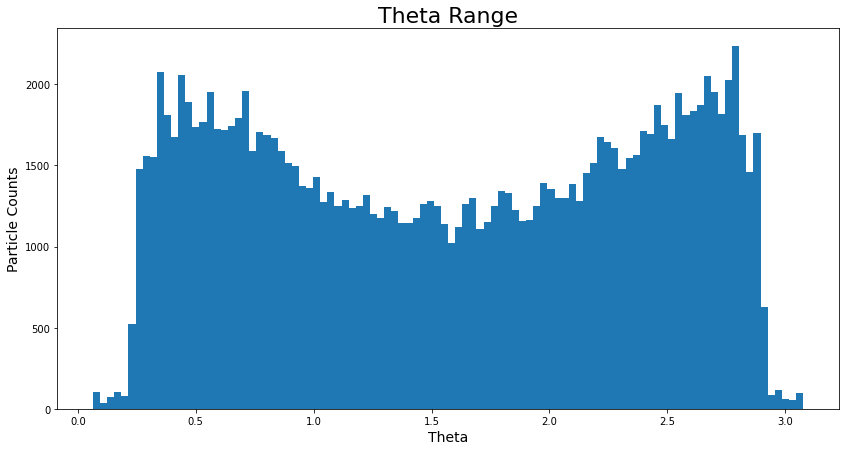

In [ ]:
#plot pt distr
fig, ax = plt.subplots(figsize = FIGSIZE)

ax.hist(df['theta'],bins=100)
ax.set_title('Theta Range',fontsize=FIG_TITLE)
ax.set_xlabel('Theta',fontsize=FIG_AXIS)
ax.set_ylabel('Particle Counts',fontsize=FIG_AXIS)
plt.show()

In [ ]:
# #plot pt distr
# fig, ax = plt.subplots(figsize = FIGSIZE)

# ax.hist(df['theta2'],bins=100)
# ax.set_title('Theta2 Range',fontsize=FIG_TITLE)
# ax.set_xlabel('Theta2',fontsize=FIG_AXIS)
# ax.set_ylabel('Particle Counts',fontsize=FIG_AXIS)
# plt.show()

# Create new hit section id

In [ ]:
df['Section_unique_id'] = df.layer_id * df.volume_id + (df.layer_id + df.volume_id)

In [ ]:
new_sec = df[['layer_id','volume_id','Section_unique_id']].value_counts().reset_index(name='hits_per_layer').sort_values(by=['volume_id','layer_id'])
new_sec

,layer_id,volume_id,Section_unique_id,hits_per_layer
3,2,8,26,16129
2,4,8,44,16741
1,6,8,62,16993
5,8,8,80,14856
0,2,13,41,17976
4,4,13,69,15742
6,6,13,97,13264
7,8,13,125,10408
8,2,17,53,7810
9,4,17,89,5436


In [ ]:
cons_layers = new_sec.Section_unique_id.unique()
cons_layers

array([ 26,  44,  62,  80,  41,  69,  97, 125,  53,  89])

# Create Sections

In [ ]:
#use only important columns
df = df[['new_hit_id', 'new_particle_id', 'Section_unique_id','x', 'y', 'z','pt', 'r', 'phi','ita','event_id']]

In [ ]:
phi_range = (-np.pi, np.pi)
ita_range =  (-3, 3)
n_phi_sections = 8          # Towards a realistic track reconstruction algorithm based
n_ita_sections = 2          #on graph neural networks for the HL-LHC

phi_edges = np.linspace(*phi_range, num=n_phi_sections+1)   #9 sections in range of phi 
ita_edges = np.linspace(*ita_range, num=n_ita_sections+1)   #3 sections in range of ita
def split_detector_sections(df, phi_edges, ita_edges):
    """Split hits according to provided phi and ita boundaries."""
    hits_sections = []
    # Loop over sections on phi
    for i in range(len(phi_edges) - 1):
        phi_min, phi_max = phi_edges[i], phi_edges[i+1]    #min and max phi in cosnecutive phi sections
        # Select hits in this phi section
        phi_hits = df[(df.phi >= phi_min) & (df.phi < phi_max)]
        # Center these hits on phi=0
        centered_phi = phi_hits.phi - (phi_min + phi_max) / 2
        phi_hits = phi_hits.assign(sec_phi=centered_phi, phi_section=i)
        #loop over sections on phi
        for j in range(len(ita_edges) - 1):
            ita_min, ita_max = ita_edges[j], ita_edges[j+1]
            # Select hits in this ita section
            # ita,theta = calc_ita(phi_hits.r, phi_hits.pz)  #CHECK THIS 
            sec_hits = phi_hits[(df['ita'] >= ita_min) & (df['ita'] < ita_max)]
            hits_sections.append(sec_hits.assign(ita_section=j))
    
    return hits_sections
df_sections = split_detector_sections(df, phi_edges, ita_edges)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


# Create graph data

In [ ]:

df_sections[0].loc[df_sections[0].new_particle_id==544935898525996009]

,new_hit_id,new_particle_id,Section_unique_id,x,y,z,pt,r,phi,ita,event_id,sec_phi,phi_section,ita_section
409,92099,544935898525996009,125,-526.348022,-395.260986,-751.599976,0.287511,658.235168,-2.497484,-0.978202,1000,0.251410,0,0
410,108511,544935898525996009,53,-814.364990,-101.620003,-580.200012,0.287511,820.680786,-3.017450,-0.658370,1000,-0.268557,0,0


In [ ]:
df_sections[2].loc[df_sections[2].new_particle_id==544935898525996009]

,new_hit_id,new_particle_id,Section_unique_id,x,y,z,pt,r,phi,ita,event_id,sec_phi,phi_section,ita_section
406,71207,544935898525996009,41,-10.300000,-263.070007,-976.599976,0.287511,263.271576,-1.609929,-2.021730,1000,0.353566,1,0
407,78553,544935898525996009,69,-102.725998,-342.890015,-926.400024,0.287511,357.947205,-1.861876,-1.679459,1000,0.101620,1,0
408,85620,544935898525996009,97,-287.170990,-415.278015,-846.885986,0.287511,504.898987,-2.175805,-1.289273,1000,-0.212310,1,0


In [ ]:
df.loc[df.new_particle_id==544935898525996009]

,new_hit_id,new_particle_id,Section_unique_id,x,y,z,pt,r,phi,ita,event_id
406,71207,544935898525996009,41,-10.300000,-263.070007,-976.599976,0.287511,263.271576,-1.609929,-2.021730,1000
407,78553,544935898525996009,69,-102.725998,-342.890015,-926.400024,0.287511,357.947205,-1.861876,-1.679459,1000
408,85620,544935898525996009,97,-287.170990,-415.278015,-846.885986,0.287511,504.898987,-2.175805,-1.289273,1000
409,92099,544935898525996009,125,-526.348022,-395.260986,-751.599976,0.287511,658.235168,-2.497484,-0.978202,1000
410,108511,544935898525996009,53,-814.364990,-101.620003,-580.200012,0.287511,820.680786,-3.017450,-0.658370,1000


In [ ]:
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 """
    dphi = phi2 - phi1
   
    return dphi



In [ ]:

#work with one df PARALELIZABLE 

def get_param_distr(df):

   #time it 
  t0 = time.time()
  dR_list, phi_slope_list,z0_list, hits_pair_list = [], [], [],[]
  for i in range(len(cons_layers)-1):
    hits1 = df.loc[df.Section_unique_id == cons_layers[i]]
    hits2 = df.loc[df.Section_unique_id == cons_layers[i+1]]
    keys = ['event_id', 'new_hit_id','Section_unique_id','new_particle_id','r', 'phi', 'z','ita']
    hit_pairs = hit_pairs = hits1[keys].reset_index().merge(hits2[keys].reset_index(), on='event_id', suffixes=('_1', '_2'))
 
    hit_pairs['y'] = hit_pairs.new_particle_id_1 == hit_pairs.new_particle_id_2


    hits_pair_list.append(hit_pairs)

  df_concat = pd.concat([hits_pair_list[0], hits_pair_list[1]], ignore_index=True)
  for i in range(len(hits_pair_list) -2):
    df_concat = pd.concat([df_concat, hits_pair_list[i+2]], ignore_index=True)


  df_concat['dphi'] = calc_dphi(df_concat.phi_1, df_concat.phi_2)
  df_concat['dz'] = df_concat.z_2 - df_concat.z_1
  df_concat['dr'] = df_concat.r_2 - df_concat.r_1
  df_concat['dita'] = df_concat.ita_2 - df_concat.ita_1
  df_concat['dR'] = np.sqrt(df_concat['dita']**2 + df_concat['dphi']**2)
  df_concat['phi_slope'] = df_concat['dphi'] / df_concat['dr']
  df_concat['z0'] = df_concat.z_1 - df_concat.r_1 * df_concat['dz'] / df_concat['dr']


  print("...  df_concat completed in {0} seconds".format(time.time()-t0))

  return df_concat

In [ ]:
df = get_param_distr(df_sections[1])

...  df_concat completed in 0.560497522354126 seconds


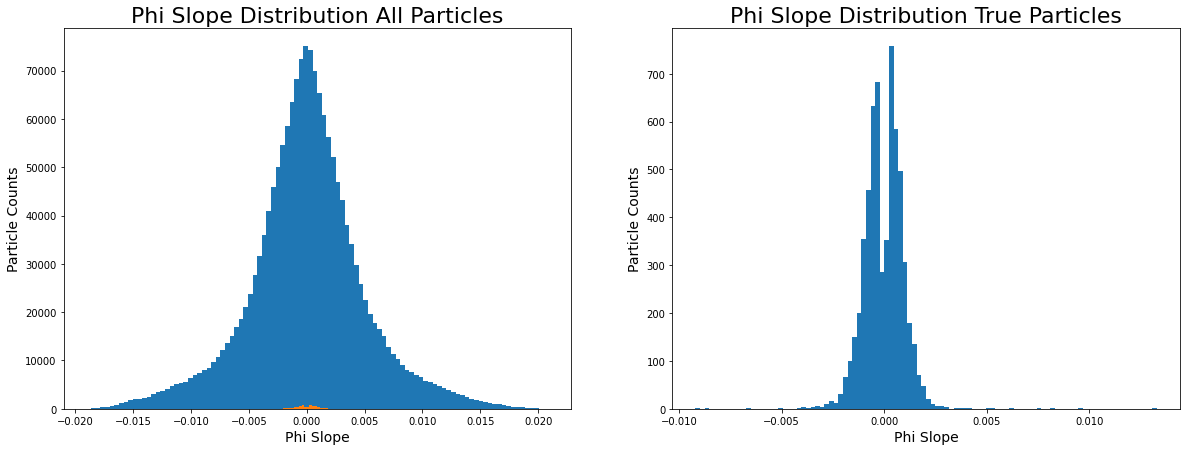

In [ ]:
fig, ax = plt.subplots(1,2,figsize = FIGSIZE2)
ax[0].hist(df.phi_slope,bins=100)
ax[0].set_title('Phi Slope Distribution All Particles',fontsize=FIG_TITLE)
ax[0].set_xlabel('Phi Slope',fontsize=FIG_AXIS)
ax[0].set_ylabel('Particle Counts',fontsize=FIG_AXIS)
ax[0].hist(df.loc[df.y==True].phi_slope,bins=100)
ax[1].hist(df.loc[df.y==True].phi_slope,bins=100)
ax[1].set_title('Phi Slope Distribution True Particles',fontsize=FIG_TITLE)
ax[1].set_xlabel('Phi Slope',fontsize=FIG_AXIS)
ax[1].set_ylabel('Particle Counts',fontsize=FIG_AXIS)
plt.show()

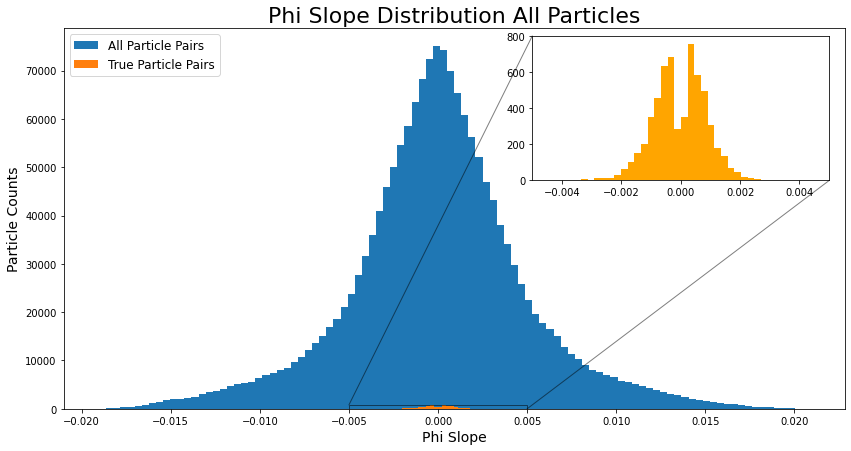

In [ ]:
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.hist(df.phi_slope,bins=100,label = 'All Particle Pairs')
ax.hist(df.loc[df.y==True].phi_slope,bins=100, label = 'True Particle Pairs')

# inset axes....
axins = ax.inset_axes([.6, 0.6, 0.38, 0.38])
axins.hist(df.loc[df.y==True].phi_slope,bins=100, color='orange')
# sub region of the original image
x1, x2, y1, y2 = -0.005,.005,0, 800
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

ax.set_title('Phi Slope Distribution All Particles',fontsize=FIG_TITLE)
ax.set_xlabel('Phi Slope',fontsize=FIG_AXIS)
ax.set_ylabel('Particle Counts',fontsize=FIG_AXIS)

ax.legend(fontsize = FIG_LEGEND)
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

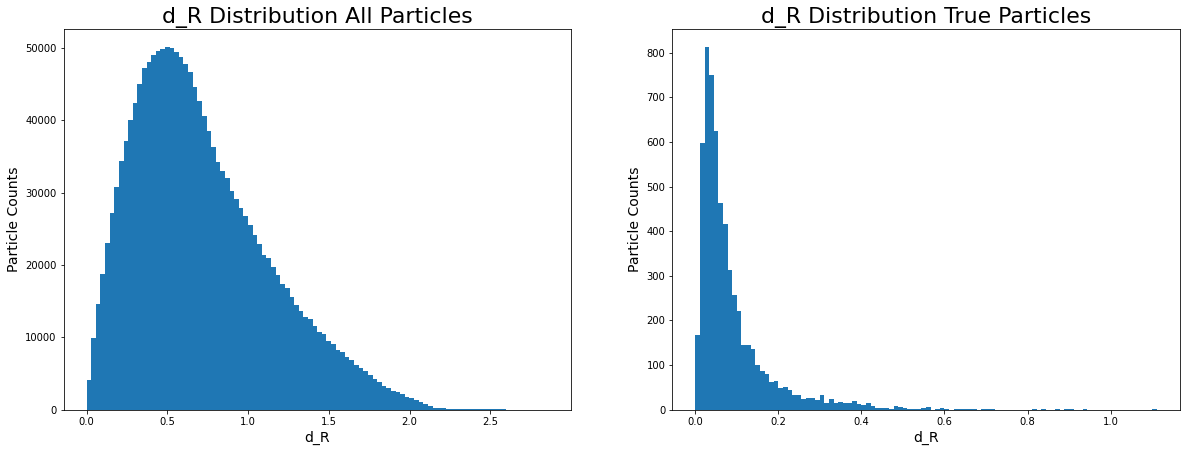

In [ ]:
fig, ax = plt.subplots(1,2,figsize = FIGSIZE2)
ax[0].hist(df.dR,bins=100)
ax[0].set_title('d_R Distribution All Particles',fontsize=FIG_TITLE)
ax[0].set_xlabel('d_R',fontsize=FIG_AXIS)
ax[0].set_ylabel('Particle Counts',fontsize=FIG_AXIS)

ax[1].hist(df.loc[df.y==True].dR,bins=100)
ax[1].set_title('d_R Distribution True Particles',fontsize=FIG_TITLE)
ax[1].set_xlabel('d_R',fontsize=FIG_AXIS)
ax[1].set_ylabel('Particle Counts',fontsize=FIG_AXIS)
plt.show()

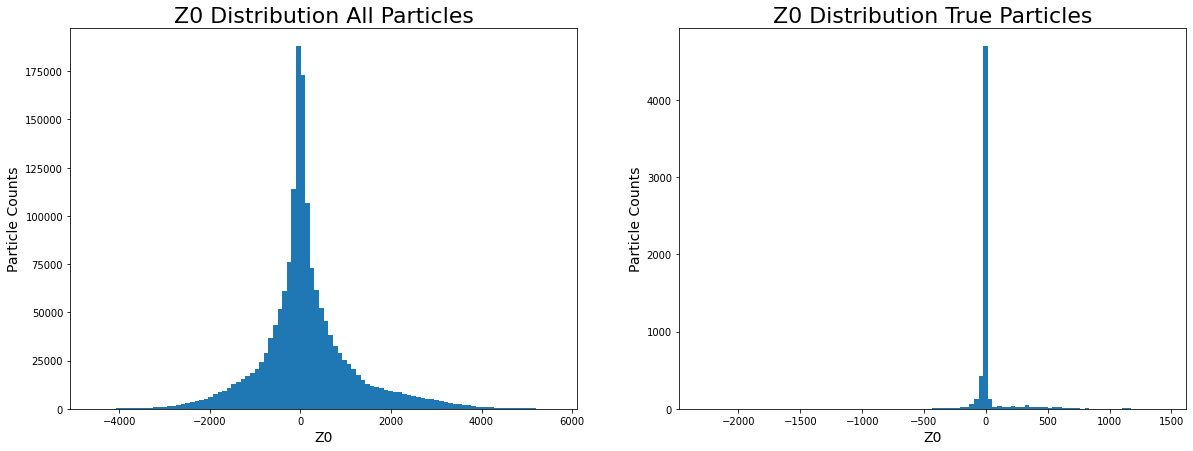

In [ ]:
fig, ax = plt.subplots(1,2,figsize = FIGSIZE2)
ax[0].hist(df.z0,bins=100)
ax[0].set_title('Z0 Distribution All Particles',fontsize=FIG_TITLE)
ax[0].set_xlabel('Z0',fontsize=FIG_AXIS)
ax[0].set_ylabel('Particle Counts',fontsize=FIG_AXIS)

ax[1].hist(df.loc[df.y==True].z0,bins=100)
ax[1].set_title('Z0 Distribution True Particles',fontsize=FIG_TITLE)
ax[1].set_xlabel('Z0',fontsize=FIG_AXIS)
ax[1].set_ylabel('Particle Counts',fontsize=FIG_AXIS)
plt.show()

In [ ]:
#filter
prev_data = len(df)
df = df.loc[(df.z0>=-2000) & (df.z0<=1500)]
z0_filter = len(df)
df = df.loc[df.dR<=1.1]
dR_filter = len(df)
df =df.loc[(df.phi_slope>=-.01) & (df.phi_slope<.015)] 
phi_slope_filter = len(df)

In [ ]:
print(f"""Amount of possible edges without filter:
{prev_data},
amount of possible edges after z0 filter:
{z0_filter},
amount of possible edges after dR filter:
{dR_filter},
amount of possible edges after phi slope filter:
{phi_slope_filter}.
""")

Amount of possible edges without filter:
1669300,
amount of possible edges after z0 filter:
1483438,
amount of possible edges after dR filter:
1250754,
amount of possible edges after phi slope filter:
1206256.



# Neural netwrok 

In [ ]:
df.columns

Index(['index_1', 'event_id', 'new_hit_id_1', 'Section_unique_id_1',
       'new_particle_id_1', 'r_1', 'phi_1', 'z_1', 'ita_1', 'index_2',
       'new_hit_id_2', 'Section_unique_id_2', 'new_particle_id_2', 'r_2',
       'phi_2', 'z_2', 'ita_2', 'y', 'dphi', 'dz', 'dr', 'dita', 'dR',
       'phi_slope', 'z0'],
      dtype='object')

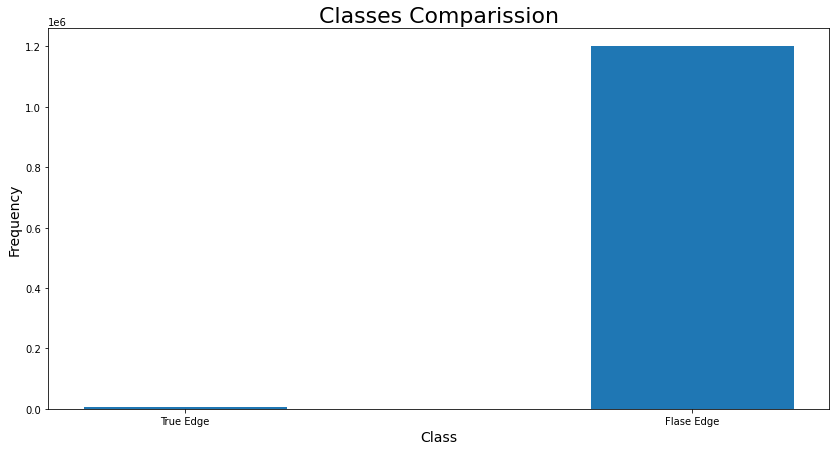

In [ ]:
#split the data 
X = df[[ 'r_1', 'phi_1', 'z_1', 'ita_1','r_2','phi_2', 'z_2', 'ita_2']]
y = df.y
count_classes = pd.value_counts(y, sort = True)


fig, ax = plt.subplots(figsize = FIGSIZE)

ax.bar([1,0],count_classes,width=0.4)
ax.set_title('Classes Comparission',fontsize=FIG_TITLE)
ax.set_xlabel('Class',fontsize=FIG_AXIS)
ax.set_ylabel('Frequency',fontsize=FIG_AXIS)
plt.xticks(range(2), ['True Edge', 'Flase Edge'])
plt.show()



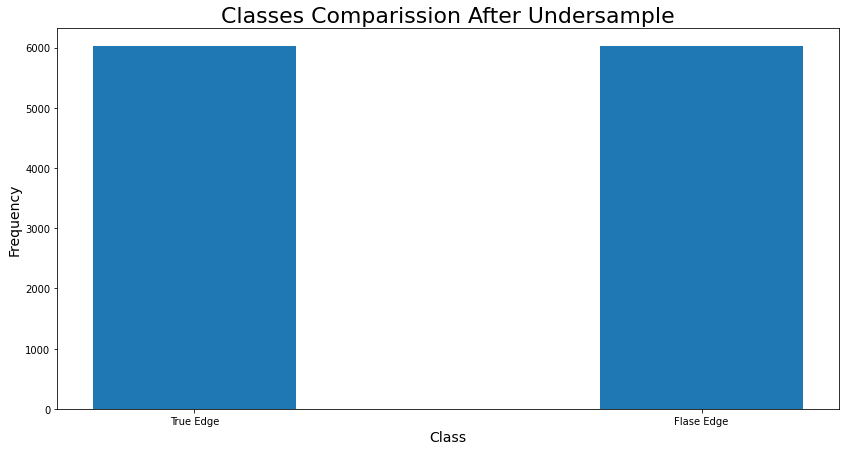

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
X_res.shape,y_res.shape
count_classes = pd.value_counts(y_res, sort = True)

fig, ax = plt.subplots(figsize = FIGSIZE)
ax.bar([1,0],count_classes,width=0.4)
ax.set_title('Classes Comparission After Undersample',fontsize=FIG_TITLE)
ax.set_xlabel('Class',fontsize=FIG_AXIS)
ax.set_ylabel('Frequency',fontsize=FIG_AXIS)
plt.xticks(range(2), ['True Edge', 'Flase Edge'])
plt.show()

In [ ]:
#create a simple XGB classifier

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.4, random_state=1)

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
#time it 
t0 = time.time()
model.fit(X_train, y_train)
print("... XGB model train completed in in {0} seconds".format(time.time()-t0))
#time it 
t0 = time.time()
y_pred = model.predict(X_test)
print("... Predictions completed in in {0} seconds".format(time.time()-t0))
accuracy = accuracy_score(y_test, y_pred)
print(f"... Accuracy = {accuracy}")


... XGB model train completed in in 1.0421156883239746 seconds
... Predictions completed in in 0.014732837677001953 seconds
... Accuracy = 0.8538205980066446


In [ ]:
#create a simple MLP Classifier
model = MLPClassifier(hidden_layer_sizes=(200,100), random_state=1, max_iter= 300)
#time it 
t0 = time.time()
model.fit(X_train, y_train)
print("... MLPClassifier model train completed in in {0} seconds".format(time.time()-t0))
#time it 
t0 = time.time()
y_pred = model.predict(X_test)
print("... Predictions completed in in {0} seconds".format(time.time()-t0))
accuracy = accuracy_score(y_test, y_pred)
print(f"... Accuracy = {accuracy}")

... MLPClassifier model train completed in in 3.286027193069458 seconds
... Predictions completed in in 0.01593923568725586 seconds
... Accuracy = 0.8766611295681063


In [ ]:
#pytorch classifier 
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [ ]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train.values), 
                       torch.FloatTensor(y_train.values))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test.values))

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(8, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=8, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
      #  print(X_batch.shape, y_batch.shape)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.53503 | Acc: 72.451
Epoch 002: | Loss: 0.41120 | Acc: 82.177
Epoch 003: | Loss: 0.37791 | Acc: 84.168
Epoch 004: | Loss: 0.35523 | Acc: 85.646
Epoch 005: | Loss: 0.34622 | Acc: 86.619
Epoch 006: | Loss: 0.34570 | Acc: 86.389
Epoch 007: | Loss: 0.32696 | Acc: 87.009
Epoch 008: | Loss: 0.33332 | Acc: 86.965
Epoch 009: | Loss: 0.32222 | Acc: 87.761
Epoch 010: | Loss: 0.32663 | Acc: 87.274
Epoch 011: | Loss: 0.32224 | Acc: 87.646
Epoch 012: | Loss: 0.31267 | Acc: 87.903
Epoch 013: | Loss: 0.31135 | Acc: 88.257
Epoch 014: | Loss: 0.30844 | Acc: 88.212
Epoch 015: | Loss: 0.30321 | Acc: 88.257
Epoch 016: | Loss: 0.30939 | Acc: 88.009
Epoch 017: | Loss: 0.31257 | Acc: 87.973
Epoch 018: | Loss: 0.31191 | Acc: 87.903
Epoch 019: | Loss: 0.30735 | Acc: 88.407
Epoch 020: | Loss: 0.30312 | Acc: 88.566
Epoch 021: | Loss: 0.29937 | Acc: 88.991
Epoch 022: | Loss: 0.29237 | Acc: 89.044
Epoch 023: | Loss: 0.29644 | Acc: 88.965
Epoch 024: | Loss: 0.29632 | Acc: 88.814
Epoch 025: | Los

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix(y_test, y_pred_list)

array([[2101,  329],
       [ 196, 2190]])

In [ ]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

       False       0.91      0.86      0.89      2430
        True       0.87      0.92      0.89      2386

    accuracy                           0.89      4816
   macro avg       0.89      0.89      0.89      4816
weighted avg       0.89      0.89      0.89      4816

